# Sample Dashboard for COVID-19

### 1. Required Python libraries

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import requests
from datetime import datetime

### 2. Request data from web service (esri website)
- https://coronavirus-resources.esri.com/datasets/bbb2e4f589ba40d692fab712ae37b9ac_1/geoservice?geometry=34.182%2C-38.069%2C-16.794%2C63.033&orderBy=Country_Region&selectedAttribute=Confirmed&where=Last_Update%20%3E%3D%20TIMESTAMP%20%272020-02-23%2000%3A00%3A00%27%20AND%20Last_Update%20%3C%3D%20TIMESTAMP%20%272020-04-25%2023%3A59%3A59%27

In [10]:
raw= requests.get("https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json")
raw_json = raw.json()
df = pd.DataFrame(raw_json["features"])
df.head()

attributes  \
0  {'OBJECTID': 1, 'Province_State': None, 'Count...   
1  {'OBJECTID': 2, 'Province_State': None, 'Count...   
2  {'OBJECTID': 3, 'Province_State': None, 'Count...   
3  {'OBJECTID': 4, 'Province_State': None, 'Count...   
4  {'OBJECTID': 5, 'Province_State': None, 'Count...   

                                            geometry  
0   {'x': 67.70995300000004, 'y': 33.93911000000003}  
1  {'x': 20.168300000000045, 'y': 41.15330000000006}  
2  {'x': 1.6596000000000686, 'y': 28.033900000000...  
3  {'x': 1.5218000000000416, 'y': 42.50630000000007}  
4  {'x': 17.87390000000005, 'y': -11.202699999999...

#### To view the values of the attributes in more detail, we can just select one of the items

In [11]:
df['attributes'][0]

{'OBJECTID': 1,
 'Province_State': None,
 'Country_Region': 'Afghanistan',
 'Last_Update': 1626337280000,
 'Lat': 33.93911,
 'Long_': 67.709953,
 'Confirmed': 136643,
 'Recovered': 82586,
 'Deaths': 5923,
 'Active': 48134,
 'Admin2': None,
 'FIPS': None,
 'Combined_Key': 'Afghanistan'}

#### From the preview, we can see the COVID-19 records consists of a list of dictionaries which includes geographical attributes (e.g. Province_State, Country_Region, Lat, Long_) and the number attributes (e.g. Confirmed, Recovered, Deaths). Besides, it also includes a timestamp attribute (Last_Update).

### 3. Transforming data

#### From the previous part, we learn the COVID-19 records are structured as a list of dictionaries and here we try to transform them into a new Pandas data frame, df_final. To do so, <ol> <li>We first use tolist method to convert the dictionary to a list, data_list<li>It is followed by using the data_list to build a new dataframe, df_final<li> Next, we use the set_index method to set the “OBJECTID” attribute as an index for every record<li> At last, reorder the columns in the df_final data frame<li>preview the transformed records.

In [12]:
data_list = df["attributes"].tolist()
df_final = pd.DataFrame(data_list)
df_final.set_index("OBJECTID")
df_final = df_final[["Country_Region", "Province_State", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Last_Update"]]
df_final.head()

Country_Region Province_State       Lat      Long_  Confirmed  Deaths  \
0    Afghanistan           None  33.93911  67.709953     136643    5923   
1        Albania           None  41.15330  20.168300     132616    2456   
2        Algeria           None  28.03390   1.659600     148797    3882   
3        Andorra           None  42.50630   1.521800      14167     127   
4         Angola           None -11.20270  17.873900      40327     946   

   Recovered   Last_Update  
0      82586  1.626337e+12  
1     130059  1.626337e+12  
2     103192  1.626337e+12  
3      13796  1.626337e+12  
4      34584  1.626337e+12

### 4. Cleaning data

> Apparently the transformed data looks fine but there are still two remaining issues here:
There are some missing values, na, in the “Last_Update” and “Province_State” columns.
The value in the “Last_Update” column is a timestamp in milliseconds which doesn’t carry much meaning about the date.<br>
To handle the first issue, we can use "dropna" method to remove the missing values from the column “Last_Update” and "fillna" method to replace all the missing values in column “Province_State” with an empty string <br>
To resolve the second issue, a function convertTime is written to convert the timestamp into a date with format “yyyy-mm-dd-hh-mm-ss” using fromtimestamp method. The column “Last_Update” is first divided by 1000 and then followed by applying the convertTime function to the entire column.

In [13]:
def convertTime(t):
    t = int(t)
    return datetime.fromtimestamp(t)

df_final = df_final.dropna(subset=["Last_Update"])
df_final["Province_State"].fillna(value="", inplace=True)

df_final["Last_Update"]= df_final["Last_Update"]/1000
df_final["Last_Update"] = df_final["Last_Update"].apply(convertTime)

df_final.head()

Country_Region Province_State       Lat      Long_  Confirmed  Deaths  \
0    Afghanistan                 33.93911  67.709953     136643    5923   
1        Albania                 41.15330  20.168300     132616    2456   
2        Algeria                 28.03390   1.659600     148797    3882   
3        Andorra                 42.50630   1.521800      14167     127   
4         Angola                -11.20270  17.873900      40327     946   

   Recovered         Last_Update  
0      82586 2021-07-15 10:21:20  
1     130059 2021-07-15 10:21:20  
2     103192 2021-07-15 10:21:20  
3      13796 2021-07-15 10:21:20  
4      34584 2021-07-15 10:21:20

### 5. Aggregating data

> Currently, the cumulative sum of the confirmed, recovered and death cases in the records are province-based but not country-based. One of the aims to build this dashboard is to show the top 10 country list. Hence, we need to perform data aggregation by applying summation on “Confirmed”, “Deaths” and “Recovered” columns and group the summed values by “Country_Region”. The aggregated data is assigned to a new dataframe, df_total.

In [14]:
df_total = df_final.groupby("Country_Region", as_index=False).agg(
    {
        "Confirmed" : "sum",
        "Deaths" : "sum",
        "Recovered" : "sum"
    }
)

df_total.head()

Country_Region  Confirmed  Deaths  Recovered
0    Afghanistan     136643    5923      82586
1        Albania     132616    2456     130059
2        Algeria     148797    3882     103192
3        Andorra      14167     127      13796
4         Angola      40327     946      34584

### 5. Calculating daily total of COVID-19 cases

At this stage, we are ready to use the transformed and aggregated data from previous parts to calculate the total number of COVID-19 cases in two levels:
Global level
Top ten countries level
<p>
Step 1: Global level <br>
The calculation of daily total of COVID-19 cases at the global level is very straightforward. We just apply sum method to “Confirmed”, “Recovered” and “Deaths” columns of df_final. The sum method will total up all the values in each of the three columns and assigned the final sum to their respective variables, total_confirmed, total_recovered, and total_deaths.

In [15]:
total_confirmed = df_final["Confirmed"].sum()
total_recovered = df_final["Recovered"].sum()
total_deaths = df_final["Deaths"].sum()

Step 2: Top ten countries level <br>
Pandas offer a handy method, nlargest, which enables us to select the top ten values in a particular column of a dataframe. To select the top 10 countries with the highest confirmed cases, we pass an n-largest value and a column name to nlargest method and assign the returned dataframe to a new variable, df_top10. Next, we generate the country name list and the total list of confirmed cases and assign them to two new variables, top10_countries_1 and top10_confirmed, respectively.
Next, repeat the similar steps above to get the top ten country data for recovered and deaths cases.

In [16]:
df_top10 = df_total.nlargest(10, "Confirmed")
top10_countries_1 = df_top10["Country_Region"].tolist()
top10_confirmed = df_top10["Confirmed"].tolist()

df_top10 = df_total.nlargest(10, "Recovered")
top10_countries_2 = df_top10["Country_Region"].tolist()
top10_recovered = df_top10["Recovered"].tolist()

df_top10 = df_total.nlargest(10, "Deaths")
top10_countries_3 = df_top10["Country_Region"].tolist()
top10_deaths = df_top10["Deaths"].tolist()

### 6. Building a dashboard using Python Plotly Subplots

The dashboard is expected to display the following info: <p>
The daily grand total of confirmed, recovered and death cases around the world <p>
The total number of confirmed, recovered, and death cases in each individual country around the world.<p>
Top ten countries with the highest number of confirmed, recovered, and death cases, respectively.<p>
We will create several subplots (one for each part of the info) using Python Plotly Subplots and join them into a single dashboard.

Step 1: Initialize subplots layout<p>
Python Plotly library offers a make_subplots function to enable us to initialize the layout arrangement for the subplots. We can set the number of rows and columns to position each of the subplots in our dashboard.<p>
In this case, we define 4 rows and 6 columns in our subplots layout. We set <p>
Row 1 Col 1:
scattergeo plot — to show the total number of confirmed, recovered, and death cases in each individual country on a map<p>
Row 1 Col 4–6:
indicator plot — to show the daily grand total of confirmed, recovered and death cases around the world<p>
Row 2 Col 4:
bar plot — to show the top 10 countries with the highest number of confirmed cases<p>
Row 3 Col 4:
bar plot — to show the top 10 countries with the highest number of recovered cases<p>
Row 4 Col 4:
bar plot — to show the top 10 countries with the highest number of death cases

In [17]:
fig = make_subplots(
    rows = 4, cols = 6,
    specs=[
            [{"type": "scattergeo", "rowspan": 4, "colspan": 3}, None, None, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"} ],
            [    None, None, None,               {"type": "bar", "colspan":3}, None, None],
            [    None, None, None,              {"type": "bar", "colspan":3}, None, None],
            [    None, None, None,               {"type": "bar", "colspan":3}, None, None],
          ]
)

Step 2: Create annotation text <p>
Prior to generating a subplot for the scattergeo map (which will be presented in the next step), we need to define an annotation text. The annotation text will be displayed whenever a user hovers the mouse over a country on the map. The annotation text shall show the country name, the confirmed, deaths, and recovered cases and the last updated date.

In [19]:
message = df_final["Country_Region"] + " " + df_final["Province_State"] + "<br>"
message += "Confirmed: " + df_final["Confirmed"].astype(str) + "<br>"
message += "Deaths: " + df_final["Deaths"].astype(str) + "<br>"
message += "Recovered: " + df_final["Recovered"].astype(str) + "<br>"
message += "Last updated: " + df_final["Last_Update"].astype(str)
df_final["text"] = message

Step 3: Create subplot — Scattergeo map<p>
To create a Scattergeo map, we can use the Python Plotly go.Scattergeo graph object. We set the “Long_” and “Lat” data from the previously generated dataframe, df_final to lon and lat property.<p> Next, we set the annotation text, df_final[“text”], to hovertext property. This will enable the predefined annotation text (from Step 2) displayed on the map whenever a user hover the mouse over a country/region.<p>
Next, we proceed to set the parameter values for marker such as size, opacity, symbol, color, etc. The parameter I wish to highlight here is the “color” property. We set the data series of confirmed cases, df_final[‘Confirmed’], to the “color” property. The go.Scattergeo graph object will generate a color scale for the markers (square box)displayed on the map based on the level of confirmed cases in each country.<p>
At last, we set this subplot of the Scattergeo map positioned in row 1 and col 1 (Line 27).

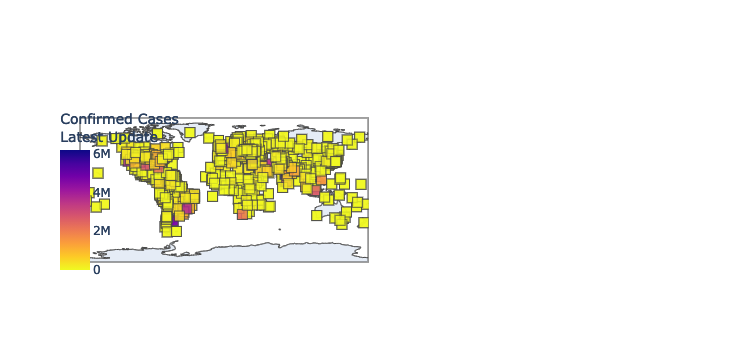

In [21]:
fig.add_trace(
    go.Scattergeo(
        locationmode = "country names",
        lon = df_final["Long_"],
        lat = df_final["Lat"],
        hovertext = df_final["text"],
        showlegend=False,
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = True,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            cmin = 0,
            color = df_final['Confirmed'],
            cmax = df_final['Confirmed'].max(),
            colorbar_title="Confirmed Cases<br>Latest Update",  
            colorbar_x = -0.05
        )

    ),
    
    row=1, col=1
)

Step 4: Create subplot — Indicator<p>
We create three indicators that display the daily total of confirmed, recovered, and death cases around the world using Plotly go.Indicator object. We set the total_confirmed, to value property, and set the title as “Confirmed Caes”. This will generate an indicator titled “Confirmed Cases” and the total number of confirmed cases will be displayed below the title.
<p>
At last, we set this subplot of the indicator positioned in row 1 and col 4.
We repeat the similar step presented above to create indicators for recovered cases and deaths cases and position them to the appropriate row and col number.

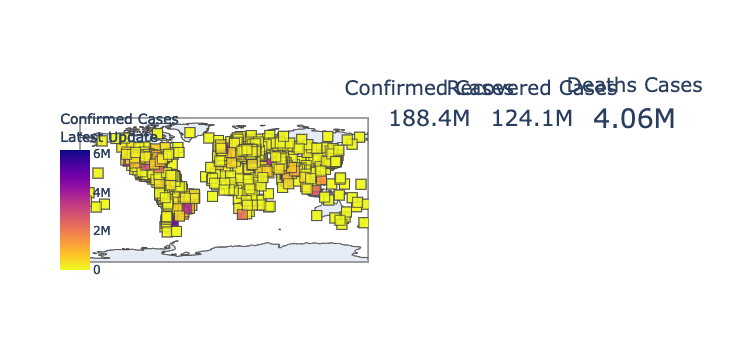

In [22]:
fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_confirmed,
        title="Confirmed Cases",
    ),
    row=1, col=4
)

fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_recovered,
        title="Recovered Cases",
    ),
    row=1, col=5
)

fig.add_trace(
    go.Indicator(
        mode="number",
        value=total_deaths,
        title="Deaths Cases",
    ),
    row=1, col=6
)

Step 5: Create subplots — Bar Charts <p>
At this stage, we shall proceed to create three bar charts to show the top ten countries with the highest number of confirmed, recovered, and death cases. We use Plotly go.bar object to create the relevant bar charts.<p>
To create a bar chart for confirmed cases, we set the top 10 country list and the top 10 number list to the x-axis and y-axis properties, respectively. <p>At last, we position the bar chart to the appropriate row and col number.<p>
We repeat similar steps to produce the bar charts for showing the top 10 countries based on the number of recovered and death cases and position them to the appropriate row and col number.

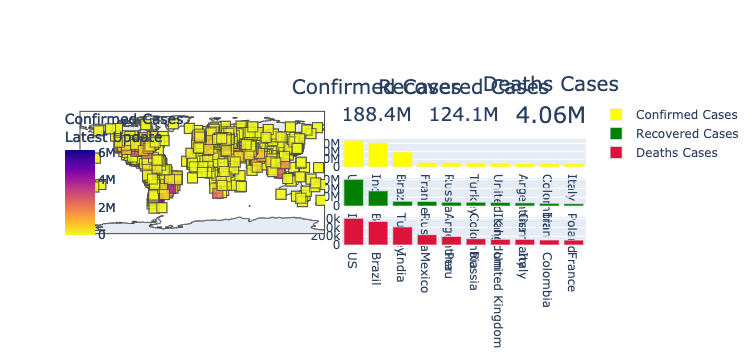

In [23]:
fig.add_trace(
    go.Bar(
        x=top10_countries_1,
        y=top10_confirmed, 
        name= "Confirmed Cases",
        marker=dict(color="Yellow"), 
        showlegend=True,
    ),
    row=2, col=4
)

fig.add_trace(
    go.Bar(
        x=top10_countries_2,
        y=top10_recovered, 
        name= "Recovered Cases",
        marker=dict(color="Green"), 
        showlegend=True),
    row=3, col=4
)

fig.add_trace(
    go.Bar(
        x=top10_countries_3,
        y=top10_deaths, 
        name= "Deaths Cases",
        marker=dict(color="crimson"), 
        showlegend=True),
    row=4, col=4
)

Step 6: Finalize layout setting <p>
This is the final step where we are going to finalize some layout settings for our subplots:<p>
template — set a dark color theme for the dashboard.<p>
title  — set a title for the dashboard and append the last updated to the title.<p>
legend  — set the legend to become visible and set it in a horizontal orientation. Define coordinate x and y to display the legend.<p>
geo — set the map displayed as an orthographic globe and display the coastline, land, and ocean on the map.<p>
annotations — set an additional annotation text on the dashboard to show the data source link at a specific coordinate x and y.<p>
Finally, we are ready to render our dashboard.

In [25]:
fig.update_layout(
    template="plotly_dark",
    title = "Global COVID-19 Cases (Last Updated: " + str(df_final["Last_Update"][0]) + ")",
    showlegend=True,
    legend_orientation="h",
    legend=dict(x=0.65, y=0.8),
    geo = dict(
            projection_type="orthographic",
            showcoastlines=True,
            landcolor="white", 
            showland= True,
            showocean = True,
            lakecolor="LightBlue"
    ),

    annotations=[
        dict(
            text="Source: https://bit.ly/3aEzxjK",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0.35,
            y=0)
    ]
)

fig.write_html('first_figure.html', auto_open=True)

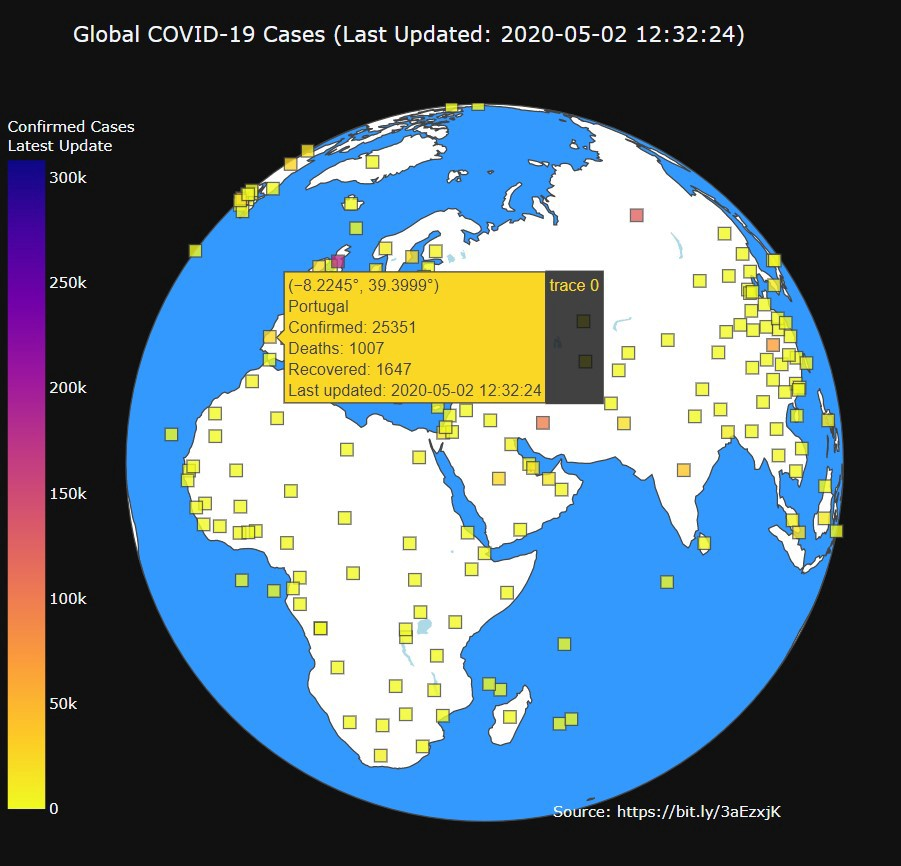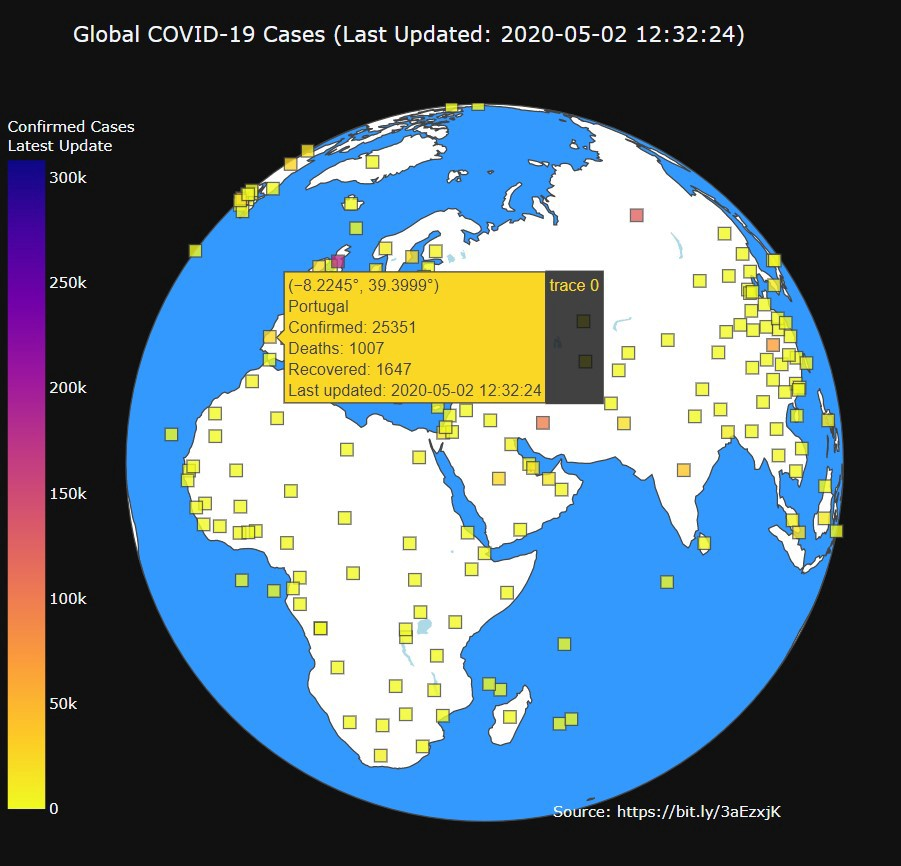

### 8. Dashboard Navigation

At first glance, we can easily view the daily total number of confirmed, recovered, and death cases from the three number indicators at the top-right corner of our dashboard.<p>
Below the three number indicators, there are three bar charts that show the top ten countries with the highest number of confirmed, recovered, and death cases.<p>
To view the COVID-19 data from an individual country/region, we can just place our mouse over one of the markers (square) on the map and an annotation text that displays the number of confirmed, recovered, and death cases reported in that country/region will appear.<p>
We can rotate the orthographic map by using the Pan Tool. Just click on the Pan Tool at the top right corner of the dashboard and click on the map and drag it to left or right direction.

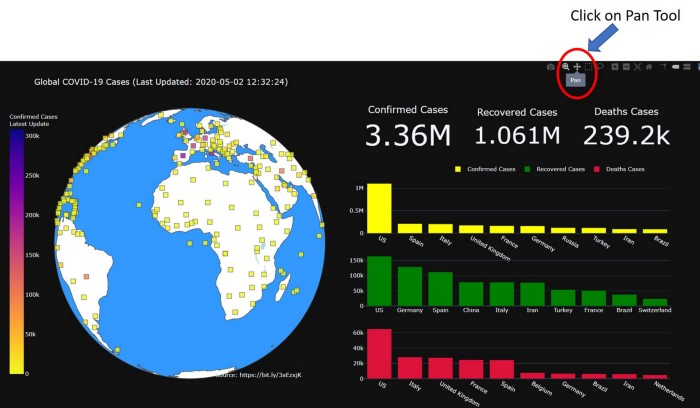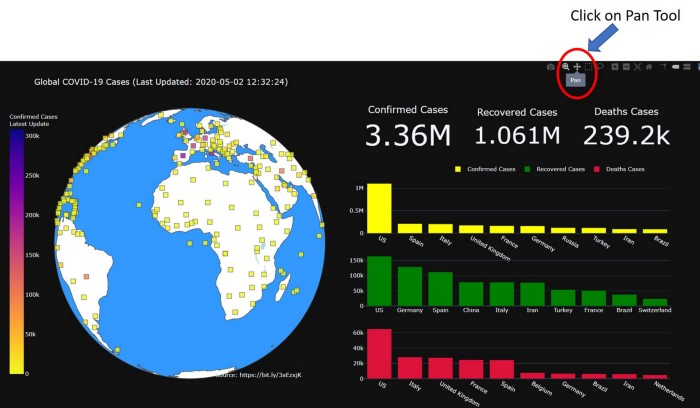